In [2]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import random
from scipy.fft import fft
from scipy.stats import mode
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 2. Shuffle and split subjects randomly
file_paths = glob.glob(os.path.join('/Users/spartan/Desktop/MLproject/har70plus', '*'))

random.seed(42)  # for reproducibility
random.shuffle(file_paths)

# 80% train, 20% test
split_idx = int(0.7 * len(file_paths))
train_file_paths = file_paths[:split_idx]
test_file_paths = file_paths[split_idx:]

print(f"Training subjects: {len(train_file_paths)}, Testing subjects: {len(test_file_paths)}")

# 3. Fourier-only feature extraction function
def extract_fft_features(window_df, sampling_rate=50):
    features = {}
    
    sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
    window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
    window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
    for col in sensor_cols + ['back_mag', 'thigh_mag']:
        arr = window_df[col].to_numpy()
        fft_vals = np.abs(fft(arr))
        n = len(arr)
        
        freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
        dom_idx = np.argmax(fft_vals[1:]) + 1
        dom_freq = abs(freqs[dom_idx])
        
        spectral_energy = np.sum(fft_vals**2)
        
        features[f'{col}_dom_freq_hz'] = dom_freq
        features[f'{col}_spectral_energy'] = spectral_energy
    
    return features

# 3. Updated Fourier + Statistical Feature Extraction
from scipy.stats import mode

# def extract_fft_stat_features(window_df, sampling_rate=50):
#     features = {}
    
#     sensor_cols = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
    
#     # Magnitude columns
#     window_df['back_mag'] = np.sqrt(window_df['back_x']**2 + window_df['back_y']**2 + window_df['back_z']**2)
#     window_df['thigh_mag'] = np.sqrt(window_df['thigh_x']**2 + window_df['thigh_y']**2 + window_df['thigh_z']**2)
    
#     for col in sensor_cols + ['back_mag', 'thigh_mag']:
#         arr = window_df[col].to_numpy()
#         fft_vals = np.abs(fft(arr))
#         n = len(arr)
        
#         freqs = np.fft.fftfreq(n, d=1/sampling_rate)
        
#         dom_idx = np.argmax(fft_vals[1:]) + 1
#         dom_freq = abs(freqs[dom_idx])
        
#         spectral_energy = np.sum(fft_vals**2)
        
#         # --- Add FFT Features ---
#         features[f'{col}_dom_freq_hz'] = dom_freq
#         features[f'{col}_spectral_energy'] = spectral_energy
        
#         # --- Add Statistical Features ---
#         features[f'{col}_mean'] = np.mean(arr)
#         features[f'{col}_median'] = np.median(arr)
#         features[f'{col}_std'] = np.std(arr)
#         features[f'{col}_mode'] = mode(arr, keepdims=False)[0]  # Using scipy's mode
        
#     return features


# 4. Process a subject file
def process_subject_fft(file_path, window_size_seconds=5, sampling_rate=50):
    df = pd.read_csv(file_path)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    
    features_list = []
    labels_list = []
    
    start_idx = 0
    total_samples = df.shape[0]
    
    while start_idx < total_samples:
        start_time = df.iloc[start_idx]['timestamp']
        end_time = start_time + pd.Timedelta(seconds=window_size_seconds)
        
        window_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
        
        if len(window_df) < 10:
            start_idx += 1
            continue
        
        features = extract_fft_features(window_df, sampling_rate)
        # features = extract_fft_stat_features(window_df, sampling_rate)
        majority_label = Counter(window_df['label']).most_common(1)[0][0]
        
        features_list.append(features)
        labels_list.append(majority_label)
        
        start_idx = window_df.index[-1] + 1
        
    return pd.DataFrame(features_list), labels_list

# 5. Process all files
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

for file in train_file_paths:
    features_df, labels = process_subject_fft(file)
    X_train_list.append(features_df)
    y_train_list.extend(labels)

for file in test_file_paths:
    features_df, labels = process_subject_fft(file)
    X_test_list.append(features_df)
    y_test_list.extend(labels)

# 6. Final datasets
X_train = pd.concat(X_train_list, axis=0).reset_index(drop=True)
y_train = np.array(y_train_list)

X_test = pd.concat(X_test_list, axis=0).reset_index(drop=True)
y_test = np.array(y_test_list)

print("Final X_train shape:", X_train.shape)
print("Final X_test shape:", X_test.shape)


Training subjects: 12, Testing subjects: 6
Final X_train shape: (5973, 16)
Final X_test shape: (3162, 16)



Training: Random Forest
Accuracy: 0.9225
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1590
           1       0.96      0.83      0.89       668
           2       1.00      0.84      0.91       681
           3       0.68      0.99      0.80       223

    accuracy                           0.92      3162
   macro avg       0.89      0.91      0.89      3162
weighted avg       0.93      0.92      0.92      3162



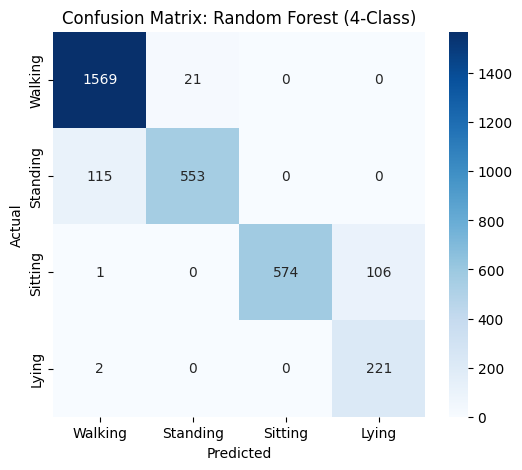


Training: Decision Tree
Accuracy: 0.9083
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1590
           1       0.91      0.76      0.83       668
           2       0.99      0.89      0.94       681
           3       0.75      0.99      0.85       223

    accuracy                           0.91      3162
   macro avg       0.89      0.90      0.89      3162
weighted avg       0.91      0.91      0.91      3162



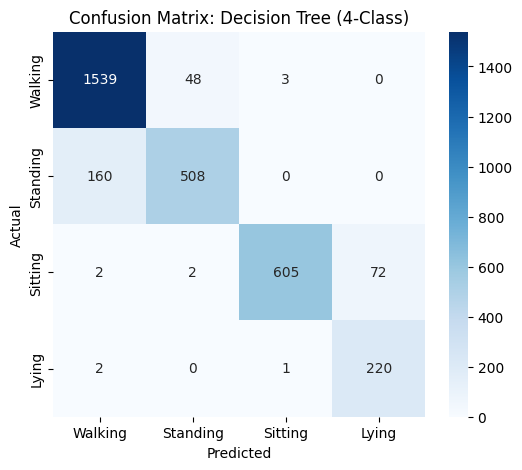


Training: Logistic Regression
Accuracy: 0.9048
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1590
           1       0.93      0.78      0.84       668
           2       1.00      0.84      0.91       681
           3       0.67      1.00      0.80       223

    accuracy                           0.90      3162
   macro avg       0.88      0.90      0.88      3162
weighted avg       0.92      0.90      0.91      3162



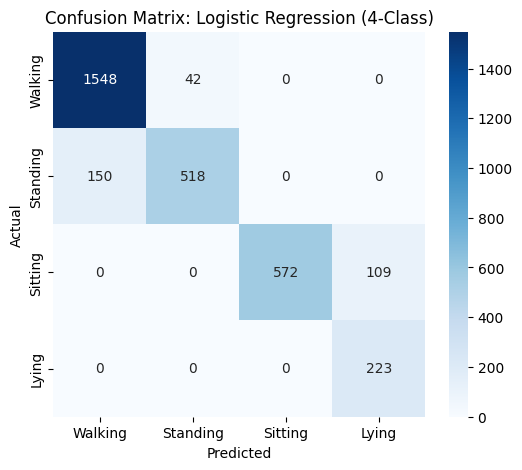


Training: SVM (Linear Kernel)
Accuracy: 0.9058
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1590
           1       0.85      0.87      0.86       668
           2       1.00      0.84      0.91       681
           3       0.67      0.99      0.80       223

    accuracy                           0.91      3162
   macro avg       0.87      0.91      0.88      3162
weighted avg       0.92      0.91      0.91      3162



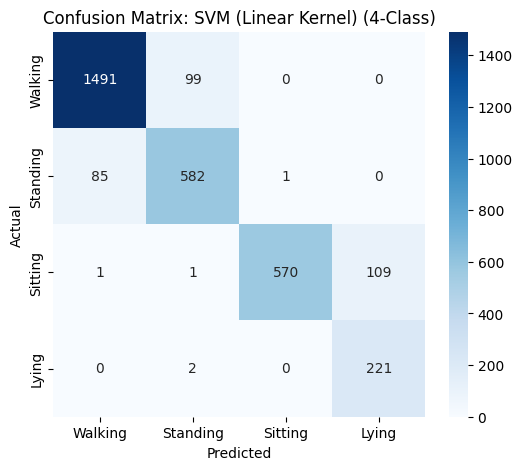


Training: SVM (RBF Kernel)
Accuracy: 0.9048
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1590
           1       0.82      0.92      0.87       668
           2       1.00      0.84      0.91       681
           3       0.68      0.99      0.80       223

    accuracy                           0.90      3162
   macro avg       0.86      0.92      0.88      3162
weighted avg       0.92      0.90      0.91      3162



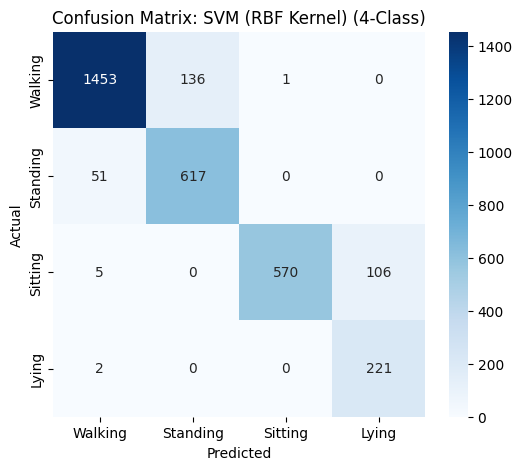


Training: K-Nearest Neighbors (KNN)
Accuracy: 0.8833
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1590
           1       0.93      0.69      0.79       668
           2       0.98      0.84      0.90       681
           3       0.66      0.95      0.78       223

    accuracy                           0.88      3162
   macro avg       0.86      0.86      0.85      3162
weighted avg       0.90      0.88      0.88      3162



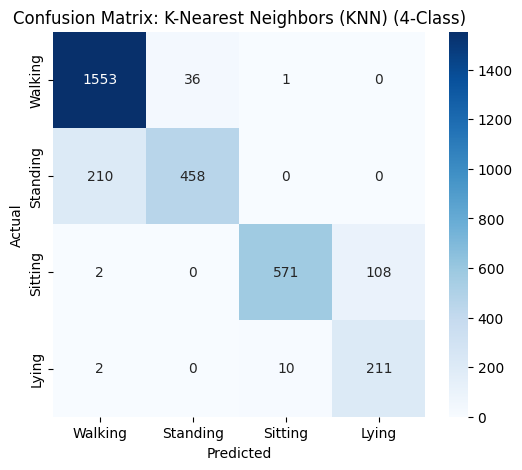


Training: Gradient Boosting
Accuracy: 0.9301
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1590
           1       0.95      0.88      0.91       668
           2       1.00      0.84      0.91       681
           3       0.67      0.98      0.80       223

    accuracy                           0.93      3162
   macro avg       0.89      0.92      0.90      3162
weighted avg       0.94      0.93      0.93      3162



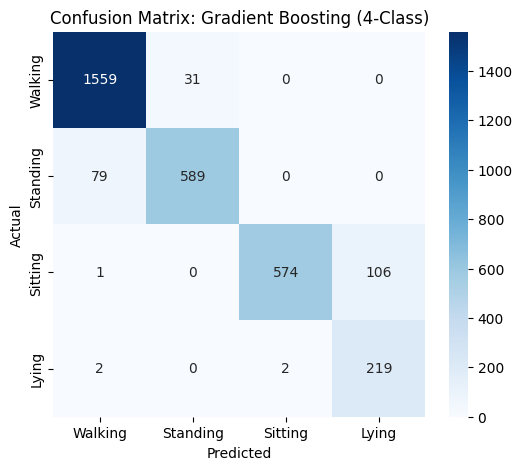


Training: AdaBoost
Accuracy: 0.7948
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1590
           1       0.90      0.57      0.70       668
           2       0.96      0.56      0.70       681
           3       0.41      0.94      0.57       223

    accuracy                           0.79      3162
   macro avg       0.78      0.76      0.72      3162
weighted avg       0.85      0.79      0.79      3162



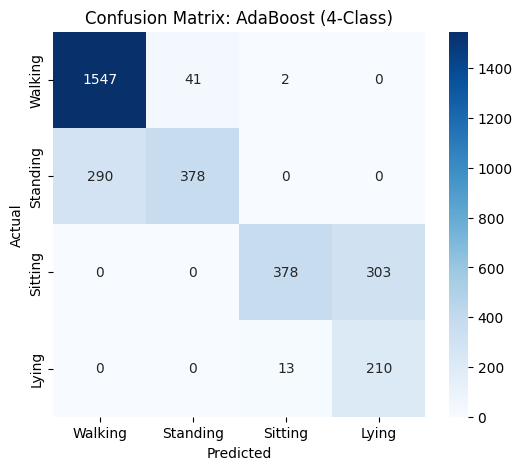


Training: Extra Trees
Accuracy: 0.9254
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1590
           1       0.96      0.87      0.91       668
           2       0.99      0.83      0.91       681
           3       0.66      0.97      0.78       223

    accuracy                           0.93      3162
   macro avg       0.89      0.91      0.89      3162
weighted avg       0.94      0.93      0.93      3162



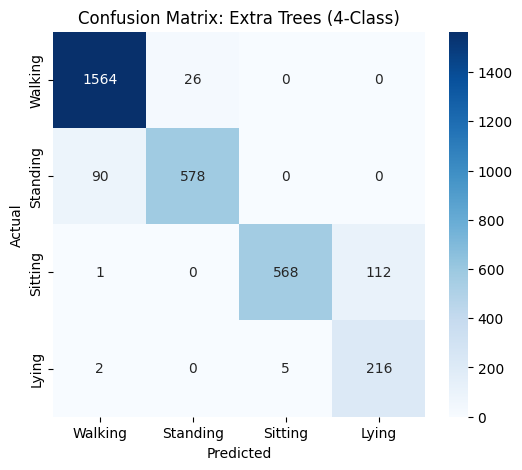


=== Model Performance Summary (4-Class) ===
Random Forest: 0.9225
Decision Tree: 0.9083
Logistic Regression: 0.9048
SVM (Linear Kernel): 0.9058
SVM (RBF Kernel): 0.9048
K-Nearest Neighbors (KNN): 0.8833
Gradient Boosting: 0.9301
AdaBoost: 0.7948
Extra Trees: 0.9254


In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# === 4-Class Classification Pipeline ===

# 1. Label Mapping for 4 Classes
label_mapping_4class = {
    1: 0, 3: 0, 4: 0, 5: 0,  # Walking-related
    6: 1,                    # Standing
    7: 2,                    # Sitting
    8: 3                     # Lying
}

y_train_4class = np.array([label_mapping_4class[lbl] for lbl in y_train])
y_test_4class = np.array([label_mapping_4class[lbl] for lbl in y_test])

# 2. Define all models
models_4class = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42, class_weight='balanced'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# 3. Train and Evaluate
results_4class = {}

for name, model in models_4class.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train_4class)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test_4class, y_pred)
    results_4class[name] = acc
    
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_4class, y_pred))

    cm = confusion_matrix(y_test_4class, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Walking", "Standing", "Sitting", "Lying"], yticklabels=["Walking", "Standing", "Sitting", "Lying"])
    plt.title(f"Confusion Matrix: {name} (4-Class)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 4. Summary
print("\n=== Model Performance Summary (4-Class) ===")
for model_name, acc in results_4class.items():
    print(f"{model_name}: {acc:.4f}")
